# Inspect Datasets and Save as Smol Objects

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from rdkit import Chem, RDLogger
from torchmetrics import MetricCollection
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

In [3]:
import fegnn.util.rdkit as smolRD
import fegnn.util.functional as smolF
import fegnn.util.metrics as Metrics
from fegnn.util.tokeniser import Vocabulary
from fegnn.util.molrepr import GeometricMol, GeometricMolBatch

In [4]:
QM9_PATH = "../../../data/qm9"
RAW_DIR ="raw"
SPLIT_DIR = "raw_split"
SAVE_DIR = "smol"
SDF_FILE = "gdb9.sdf"
METADATA_FILE = "gdb9.sdf.csv"
SKIP_FILE = "uncharacterized.txt"

In [5]:
# Copied from MiDi code, so should create the same splits (they didn't make them available)
def split_qm9(metadata_df):
    n_samples = len(metadata_df)
    n_train = 100000
    n_test = int(0.1 * n_samples)
    n_val = n_samples - (n_train + n_test)

    # Shuffle dataset with df.sample, then split
    train, val, test = np.split(metadata_df.sample(frac=1, random_state=42), [n_train, n_val + n_train])
    return train, val, test

In [6]:
# Will skip mol indices which appear in the skip file
def rdkit_mols_from_df(split_path, sdf_path, skip_path):
    target_df = pd.read_csv(split_path, index_col=0)
    target_df.drop(columns=['mol_id'], inplace=True)

    with open(skip_path, 'r') as f:
        skip = [int(x.split()[0]) - 1 for x in f.read().split('\n')[9:-2]]

    suppl = Chem.SDMolSupplier(str(sdf_path), removeHs=False, sanitize=False)

    mols = []
    all_smiles = []

    errors = 0
    skipped = 0

    for i, mol in enumerate(tqdm(suppl)):
        if i not in target_df.index:
            continue

        if i in skip:
            skipped += 1
            continue

        try:
            Chem.SanitizeMol(mol)
            smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
        except:
            smiles = None

        if smiles is None:
            errors += 1
        else:
            all_smiles.append(smiles)
            mols.append(mol)

    print(f"Skipped {skipped} mols which where in skip file.")
    print(f"Encountered {errors} molecules which failed sanitisation.")
    print(f"Completed loading of dataset with {len(mols)} molecules.")

    return mols

In [7]:
def build_vocab():
    # Need to make sure PAD has index 0
    special_tokens = ["<PAD>", "<MASK>"]
    core_atoms = ["H", "C", "N", "O", "F", "P", "S", "Cl"]
    other_atoms = ["Br", "B", "Al", "Si", "As", "I", "Hg", "Bi"]
    tokens = special_tokens + core_atoms + other_atoms
    return Vocabulary(tokens)

In [8]:
def matching_smiles(rdkit_mol, smol_mol, vocab):
    rdkit_mol2 = smol_mol.to_rdkit(vocab)
    smi1 = smolRD.smiles_from_mol(rdkit_mol, canonical=True)
    smi2 = smolRD.smiles_from_mol(rdkit_mol2, canonical=True)
    return smi1 == smi2

## QM9

### Split QM9 and load into separate CSVs

I have copied the code from the MiDi paper and used the same random seed, so hopefully this will generate the same splits as they used. But they haven't provided their splits so we can't say for sure without these.

This code just splits the csv file, which contains metadata and properties for each molecule. The full molecular coordinates are stored in a single sdf file.

In [8]:
qm9_path = Path(QM9_PATH)
dataset = pd.read_csv(qm9_path / RAW_DIR / METADATA_FILE)
train, val, test = split_qm9(dataset)

train_csv_path = qm9_path / SPLIT_DIR / "train.csv"
val_csv_path = qm9_path / SPLIT_DIR / "val.csv"
test_csv_path = qm9_path / SPLIT_DIR / "test.csv"

# train.to_csv(train_csv_path)
# val.to_csv(val_csv_path)
# test.to_csv(test_csv_path)

/home/khdv294/miniconda3/envs/fegnn/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Create Smol Datasets from RDKit Mols from SDF Files

In [9]:
RDLogger.DisableLog('rdApp.*')

In [10]:
vocab = build_vocab()

In [10]:
sdf_path = qm9_path / RAW_DIR / SDF_FILE
skip_path = qm9_path / RAW_DIR / SKIP_FILE

print("Processing train data...")
train_mols = rdkit_mols_from_df(train_csv_path, sdf_path, skip_path)

print("Processing val data...")
val_mols = rdkit_mols_from_df(val_csv_path, sdf_path, skip_path)

print("Processing test data...")
test_mols = rdkit_mols_from_df(test_csv_path, sdf_path, skip_path)

Processing train data...


  0%|          | 0/133885 [00:00<?, ?it/s][17:02:08] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 2 C, 5, is greater than permitted
  1%|          | 957/133885 [00:00<00:13, 9561.51it/s][17:02:08] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 2 C, 5, is greater than permitted
  1%|▏         | 1914/133885 [00:00<00:15, 8610.99it/s][17:02:08] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:08] Explicit valence for atom # 3 C, 5,

Skipped 2266 mols which where in skip file.
Encountered 1071 molecules which failed sanitisation.
Completed loading of dataset with 96663 molecules.
Processing val data...


  1%|          | 1467/133885 [00:00<00:09, 14667.60it/s][17:02:30] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:30] Explicit valence for atom # 1 C, 5, is greater than permitted
  2%|▏         | 3021/133885 [00:00<00:08, 15179.92it/s][17:02:30] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:02:30] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:02:30] Explicit valence for atom # 3 C, 5, is greater than permitted
  6%|▌         | 7652/133885 [00:00<00:08, 15093.10it/s][17:02:30] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:30] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:02:30] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:02:30] Explicit valence for atom # 3 C, 5, is greater than permitted
 12%|█▏        | 16391/133885 [00:01<00:12, 9751.39it/s] [17:02:31] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:02:31] Explicit valence for atom # 5 C, 5

Skipped 455 mols which where in skip file.
Encountered 207 molecules which failed sanitisation.
Completed loading of dataset with 19835 molecules.
Processing test data...


  1%|▏         | 1754/133885 [00:00<00:07, 17538.18it/s][17:02:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:41] Explicit valence for atom # 4 C, 5, is greater than permitted
  6%|▌         | 8300/133885 [00:00<00:08, 15019.48it/s][17:02:41] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:02:41] Explicit valence for atom # 3 C, 5, is greater than permitted
[17:02:41] Explicit valence for atom # 4 C, 5, is greater than permitted
 10%|▉         | 13021/133885 [00:00<00:07, 15277.02it/s][17:02:42] Explicit valence for atom # 1 C, 5, is greater than permitted
[17:02:42] Explicit valence for atom # 4 C, 5, is greater than permitted
 12%|█▏        | 16161/133885 [00:01<00:07, 15366.75it/s][17:02:42] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:42] Explicit valence for atom # 2 C, 5, is greater than permitted
[17:02:42] Explicit valence for atom # 2 C, 5, is greater than permitted
 13%|█▎        | 17700/133885 [00:01<00:07, 

Skipped 333 mols which where in skip file.
Encountered 125 molecules which failed sanitisation.
Completed loading of dataset with 12930 molecules.


In [11]:
# Create Smol batches for ease of use later on
train_batch = GeometricMolBatch([GeometricMol.from_rdkit(mol) for mol in train_mols])
val_batch = GeometricMolBatch([GeometricMol.from_rdkit(mol) for mol in val_mols])
test_batch = GeometricMolBatch([GeometricMol.from_rdkit(mol) for mol in test_mols])

In [12]:
# Check it looks right
print("Dataset sizes:")
print(len(train_batch))
print(len(val_batch))
print(len(test_batch))

example_mol = train_batch[567]
print()
print("Example mol:")
print(example_mol.coords)
print(example_mol.atomics)
print(example_mol.bonds)
print(example_mol.charges)

Dataset sizes:
96663
19835
12930

Example mol:
tensor([[ 1.0900e-02, -5.2200e-02,  3.0000e-03],
        [-1.4900e-02,  1.1581e+00,  9.8000e-03],
        [-1.1242e+00,  2.0177e+00,  2.8800e-02],
        [-6.7940e-01,  3.3149e+00,  3.0000e-02],
        [ 6.1400e-01,  3.3886e+00,  1.3500e-02],
        [ 1.0186e+00,  2.0738e+00,  9.0000e-04],
        [-2.0733e+00,  1.6883e+00,  3.9700e-02],
        [-1.3333e+00,  4.1724e+00,  4.3200e-02],
        [ 1.9968e+00,  1.8460e+00, -1.2800e-02]])
tensor([8, 6, 7, 6, 7, 7, 1, 1, 1])
tensor([[0, 1, 2],
        [1, 2, 4],
        [1, 5, 4],
        [2, 3, 4],
        [2, 6, 1],
        [3, 4, 4],
        [3, 7, 1],
        [4, 5, 4],
        [5, 8, 1]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

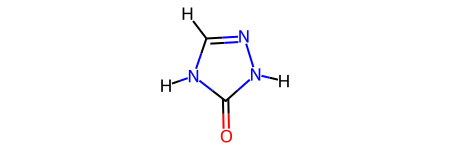

In [14]:
example_mol.to_rdkit(vocab)

In [15]:
for atom in example_mol.to_rdkit(vocab).GetAtoms():
    print(f"Atom {atom.GetSymbol()} -- charge {atom.GetFormalCharge()} -- valence {atom.GetExplicitValence()}")

Atom O -- charge 0 -- valence 2
Atom C -- charge 0 -- valence 4
Atom N -- charge 0 -- valence 3
Atom C -- charge 0 -- valence 4
Atom N -- charge 0 -- valence 3
Atom N -- charge 0 -- valence 3
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1


In [17]:
train_path = qm9_path / SAVE_DIR / "train.smol"
val_path = qm9_path / SAVE_DIR / "val.smol"
test_path = qm9_path / SAVE_DIR / "test.smol"

train_bytes = train_batch.to_bytes()
val_bytes = val_batch.to_bytes()
test_bytes = test_batch.to_bytes()

train_path.write_bytes(train_bytes)
val_path.write_bytes(val_bytes)
test_path.write_bytes(test_bytes)

29957353

In [18]:
train_matching = [matching_smiles(mol1, mol2, vocab) for mol1, mol2 in zip(train_mols, train_batch.to_list())]
print("Proportion matching", sum(train_matching) / len(train_matching))

Proportion matching 0.251130215284028


In [20]:
print(len(train_mols))
print(len(train_batch))

96663
96663


In [21]:
unmatched_idxs = [idx for idx, matching in enumerate(train_matching) if not matching]

In [26]:
idx = 100
unmatched_idx = unmatched_idxs[idx]
print(smolRD.smiles_from_mol(train_mols[unmatched_idx]))
print(smolRD.smiles_from_mol(train_batch[unmatched_idx].to_rdkit(vocab)))

[H]O[C@]1([H])C([H])([H])OC([H])([H])C1([H])[H]
[H]OC1([H])C([H])([H])OC([H])([H])C1([H])[H]


In [27]:
train_valid = [smolRD.mol_is_valid(mol.to_rdkit(vocab)) for mol in train_batch]
print("Propertion valid", sum(train_valid) / len(train_valid))

[17:16:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7
[17:16:15] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 3 4 6
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7
[17:16:17] Can't kekulize mol.  Unkekulized atoms

Propertion valid 0.9979413012217705


## Analyse QM9 Dataset

In [23]:
train_coords = train_batch.coords
train_mask = train_batch.mask

_, std_dev = smolF.standardise_coords(train_coords, train_mask)
print("Coord std dev on train data", std_dev)

Coord std dev on train data 1.723299503326416


In [24]:
avg_n_atoms = sum(train_batch.seq_length) / len(train_batch.seq_length)
max_n_atoms = max(train_batch.seq_length)
min_n_atoms = min(train_batch.seq_length)
print("avg", avg_n_atoms)
print("max", max_n_atoms)
print("min", min_n_atoms)

avg 18.033497822331192
max 29
min 3


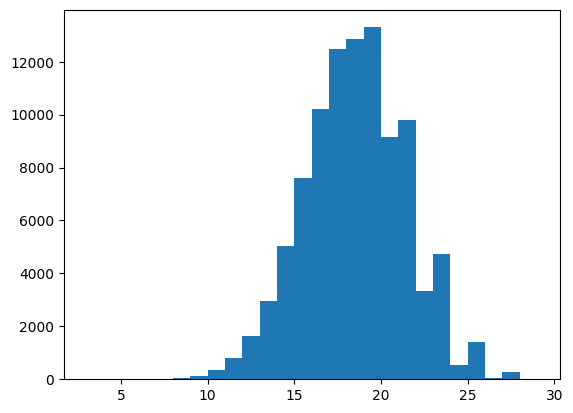

In [25]:
plt.hist(train_batch.seq_length, bins=26)
plt.show()

### Firstly, try loading the saved data

In [19]:
SAVE_DIR = "smol"

In [11]:
qm9_path = Path(QM9_PATH)
train_path = qm9_path / SAVE_DIR / "train.smol"
val_path = qm9_path / SAVE_DIR / "val.smol"
test_path = qm9_path / SAVE_DIR / "test.smol"

In [12]:
train_bytes = train_path.read_bytes()
val_bytes = val_path.read_bytes()
test_bytes = test_path.read_bytes()

train_batch = GeometricMolBatch.from_bytes(train_bytes)
val_batch = GeometricMolBatch.from_bytes(val_bytes)
test_batch = GeometricMolBatch.from_bytes(test_bytes)

In [13]:
vocab = build_vocab()

In [14]:
sample_mols = train_batch.to_list()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

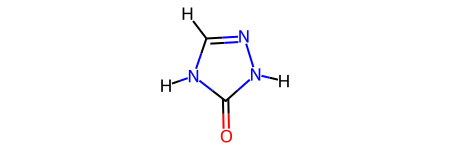

In [15]:
sample_mols[567].to_rdkit(vocab)

In [16]:
for atom in sample_mols[567].to_rdkit(vocab).GetAtoms():
    print(f"Atom {atom.GetSymbol()} -- charge {atom.GetFormalCharge()} -- valence {atom.GetExplicitValence()}")

Atom O -- charge 0 -- valence 2
Atom C -- charge 0 -- valence 4
Atom N -- charge 0 -- valence 3
Atom C -- charge 0 -- valence 4
Atom N -- charge 0 -- valence 3
Atom N -- charge 0 -- valence 3
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1


In [22]:
gen_metrics = {
    "validity": Metrics.Validity(),
    "fc-validity": Metrics.Validity(connected=True),
    "uniqueness": Metrics.Uniqueness(),
    "energy-validity": Metrics.EnergyValidity(),
    "opt-energy-validity": Metrics.EnergyValidity(optimise=True),
    "energy": Metrics.AverageEnergy(),
    "energy-per-atom": Metrics.AverageEnergy(per_atom=True),
    "strain": Metrics.AverageStrainEnergy(),
    "strain-per-atom": Metrics.AverageStrainEnergy(per_atom=True),
    "opt-rmsd": Metrics.AverageOptRmsd()
}
gen_metrics = MetricCollection(gen_metrics, compute_groups=False)

In [23]:
# Compute benchmark metrics on loaded train dataset samples
rdkit_sample_mols = [mol.to_rdkit(vocab, sanitize=True) for mol in sample_mols]
gen_metrics.reset()
gen_metrics.update(rdkit_sample_mols)
results = gen_metrics.compute()

/home/khdv294/Documents/code/equinv-flow/notebooks/../fegnn/util/rdkit.py:217: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation, _ = Rotation.align_vectors(coords1, coords2)


In [24]:
for metric, result in results.items():
    print(f"{metric} -- {result.item():.3f}")

energy -- 32.800
energy-per-atom -- 1.834
energy-validity -- 0.998
fc-validity -- 0.998
opt-energy-validity -- 0.998
opt-rmsd -- 0.234
strain -- 9.974
strain-per-atom -- 0.585
uniqueness -- 0.999
validity -- 0.998


In [44]:
# Compute benchmark metrics on original train dataset samples
gen_metrics.reset()
gen_metrics.update(train_mols)
results = gen_metrics.compute()

[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling AddHs()
[18:42:47] Molecule does not have explicit Hs. Consider calling 

In [45]:
for metric, result in results.items():
    print(f"{metric} -- {result.item():.3f}")

atom-stability -- 1.000
energy -- 32.871
energy-validity -- 1.000
fc-validity -- 1.000
molecule-stability -- 0.996
uniqueness -- 0.999
validity -- 1.000


In [68]:
for idx, mol in enumerate(sample_mols[82008:82010]):
    print(idx)
    mol.to_rdkit(vocab)

0
1


[18:52:52] Explicit valence for atom # 1 N, 4, is greater than permitted


In [71]:
idx = 82000 + 8
sample_mols[idx].to_rdkit(vocab)

[18:53:05] Explicit valence for atom # 1 N, 4, is greater than permitted


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

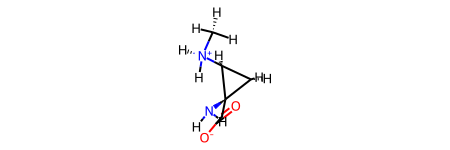

In [94]:
original_mol = Chem.Mol(train_mols[idx])
Chem.SanitizeMol(original_mol)
original_mol

### Recreate this issue with functions in the notebook

In [91]:
def mol_from_atoms(coords, tokens, bonds):
    try:
        atomics = [smolRD.PT.atomic_from_symbol(token) for token in tokens]
    except:
        return None

    # Add atom types
    mol = Chem.EditableMol(Chem.Mol())
    for atomic in atomics:
        mol.AddAtom(Chem.Atom(atomic))

    # Add 3D coords
    conf = Chem.Conformer(coords.shape[0])
    for idx, coord in enumerate(coords.tolist()):
        conf.SetAtomPosition(idx, coord)

    mol = mol.GetMol()
    mol.AddConformer(conf)

    # Add bonds if they have been provided
    mol = Chem.EditableMol(mol)
    for bond in bonds.astype(np.int32).tolist():
        start, end, b_type = bond

        if b_type not in smolRD.IDX_BOND_MAP:
            return None

        # Don't add self connections
        if start != end:
            b_type = smolRD.IDX_BOND_MAP[b_type]
            mol.AddBond(start, end, b_type)

    mol = mol.GetMol()
    for atom in mol.GetAtoms():
        atom.UpdatePropertyCache(strict=False)

    # try:
    #     Chem.SanitizeMol(mol)
    # except:
    #     return None

    return mol

In [92]:
def to_rdkit(mol, vocab):
    if len(mol.atomics.size()) == 2:
        vocab_indices = torch.argmax(mol.atomics, dim=1).tolist()
        tokens = vocab.tokens_from_indices(vocab_indices)

    else:
        atomics = mol.atomics.tolist()
        tokens = [smolRD.PT.symbol_from_atomic(a) for a in atomics]

    coords = mol.coords.numpy()
    bonds = mol.bonds.numpy()

    rdkit_mol = mol_from_atoms(coords, tokens, bonds)
    return rdkit_mol

In [96]:
idx = 82000 + 8
problem_mol = sample_mols[idx]
rdkit_mol = to_rdkit(problem_mol, vocab)

In [103]:
for atom in rdkit_mol.GetAtoms():
    print(f"Atom {atom.GetSymbol()} -- charge {atom.GetFormalCharge()} -- valence {atom.GetExplicitValence()}")

print()
for atom in original_mol.GetAtoms():
    print(f"Atom {atom.GetSymbol()} -- charge {atom.GetFormalCharge()} -- valence {atom.GetExplicitValence()}")

Atom C -- charge 0 -- valence 4
Atom N -- charge 0 -- valence 4
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom C -- charge 0 -- valence 4
Atom C -- charge 0 -- valence 4
Atom C -- charge 0 -- valence 4
Atom N -- charge 0 -- valence 3
Atom C -- charge 0 -- valence 4
Atom O -- charge 0 -- valence 1
Atom O -- charge 0 -- valence 2
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1

Atom C -- charge 0 -- valence 4
Atom N -- charge 1 -- valence 4
Atom H -- charge 0 -- valence 1
Atom H -- charge 0 -- valence 1
Atom C -- charge 0 -- valence 4
Atom C -- charge 0 -- valence 4
Atom C -- charge 0 -- valence 4
Atom N -- charge 0 -- valence 3
Atom C -- charge 0 -- valence 4
Atom O -- charge -1 -- valence 1
Atom O -- charge 0 -- valence 2
Atom H -- charge 0 -- valence 1
Atom H